# Прогнозирование оттока клиентов оператора связи «ТелеДом»


Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.
Описание услуг
Оператор предоставляет два основных типа услуг: 

    Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
    Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

    Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
    Выделенная линия технической поддержки (TechSupport);
    Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
    Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Загрузка данных" data-toc-modified-id="Загрузка данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

__Загрузка библиотек__

In [1]:
!pip install phik
!pip install numba==0.59.1
!pip install numpy==1.26.4
!pip install scipy==1.13.1
!pip install scikit-learn==1.5.0
!pip install seaborn==0.13.2
!pip install matplotlib==3.9.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, 
    make_scorer,
    precision_score, 
    auc, 
    recall_score,
    roc_curve, 
    f1_score, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

## Подготовка

In [3]:
df_list = []

In [4]:
try:
    contract_new = pd.read_csv("/datasets/contract_new.csv")
    personal_new = pd.read_csv("/datasets/personal_new.csv")
    internet_new = pd.read_csv("/datasets/internet_new.csv")
    phone_new = pd.read_csv("/datasets/phone_new.csv")
except:
    contract_new = pd.read_csv("https://code.s3.yandex.net/datasets/contract_new.csv")
    personal_new = pd.read_csv("https://code.s3.yandex.net/datasets/personal_new.csv")
    internet_new = pd.read_csv("https://code.s3.yandex.net/datasets/internet_new.csv")
    phone_new = pd.read_csv("https://code.s3.yandex.net/datasets/phone_new.csv")

In [5]:
contract_new.name = 'contract_new'
personal_new.name = 'personal_new'
internet_new.name = 'internet_new'
phone_new.name = 'phone_new'

In [6]:
df_list = [contract_new, personal_new, internet_new, phone_new]

__Функции, которые будут использоваться в проекте__

In [7]:
def data_exploration_func(df):
    print('=========================')
    print('Датасет', df.name)
    display(df.head(10))
    df.info()
    display(df.describe(include='all')) 

In [8]:
def num_func(df):
    numeric_cols = df.select_dtypes(include='number').columns

    num_plots = len(numeric_cols)
    plt.figure(figsize=(10, 5 * num_plots))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(num_plots, 2, 2*i + 1)
        df[col].hist(bins=15)
        plt.title(f'Гистограмма для {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.subplot(num_plots, 2, 2*i + 2)
        df.boxplot(column=col)
        plt.title(f'Диаграмма размаха {col}')
        
    plt.tight_layout()
    plt.show()

In [9]:
def cat_func(df):
    
    cat_cols = df.select_dtypes(exclude=['number','datetime']).columns
    
    colors = sns.color_palette('deep')
    for i in cat_cols:
        plt.title(f'Диаграмма категории {i}')
        df[i].value_counts().plot(kind='pie', 
                             legend=True, 
                             autopct='%.2f%%', 
                             textprops={'color':'white', 'size':15}, 
                             figsize=(8, 6))    
        plt.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
        plt.ylabel(None)
        plt.show()
        
        

    print("===========")

In [10]:
def has_left(end_date):
    if end_date == 'No':
        return 1
    else:
        return 0

__Константа__

In [11]:
RANDOM_STATE=281024

## Загрузка данных

In [12]:
for data in df_list:
    data_exploration_func(data)

Датасет contract_new


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,2453-SAFNS,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Датасет personal_new


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,2453-SAFNS,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


Датасет internet_new


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2453-SAFNS,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Датасет phone_new


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2453-SAFNS,No
freq,1,3390


Для этой задачи заказчик предоставил данные с признаками:

    contract_new.csv — информация о договоре;
    personal_new.csv — персональные данные клиента;
    internet_new.csv — информация об интернет-услугах;
    phone_new.csv — информация об услугах телефонии.

contract_new

    customerID — идентификатор абонента;
    BeginDate — дата начала действия договора;
    EndDate — дата окончания действия договора;
    Type — тип оплаты: раз в год-два или ежемесячно;
    PaperlessBilling — электронный расчётный лист;
    PaymentMethod — тип платежа;
    MonthlyCharges — расходы за месяц;
    TotalCharges — общие расходы абонента.

personal_new

    customerID — идентификатор пользователя;
    gender — пол;
    SeniorCitizen — является ли абонент пенсионером;
    Partner — есть ли у абонента супруг или супруга;
    Dependents — есть ли у абонента дети.

internet_new

    customerID — идентификатор пользователя;
    InternetService — тип подключения;
    OnlineSecurity — блокировка опасных сайтов;
    OnlineBackup — облачное хранилище файлов для резервного копирования данных;
    DeviceProtection — антивирус;
    TechSupport — выделенная линия технической поддержки;
    StreamingTV — стриминговое телевидение;
    StreamingMovies — каталог фильмов.

phone_new

    customerID — идентификатор пользователя;
    MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Вывод: Данные загружены. Пора приступать к предобработке данных


## Исследовательский анализ и предобработка данных

### Преобразование данных:

Добавим целевой признак - Не рассторг ли договор клиент.

In [13]:
contract_new['activeСlient'] = contract_new['EndDate'].apply(has_left)

Преобразуем в таблице personal_new столбец SeniorCitizen к общему виду 

In [14]:
personal_new["SeniorCitizen"] = personal_new["SeniorCitizen"].replace(0, "No", regex=True)
personal_new["SeniorCitizen"] = personal_new["SeniorCitizen"].replace(1, "Yes", regex=True)

Переведем в тип данных datetime столбцы BeginDate и EndDate, а также обозначим за окончание контракта дату выгрузки данных (2020-02-01)

In [15]:
contract_new['BeginDate'] = pd.to_datetime(contract_new['BeginDate'])

In [16]:
contract_new['EndDate'] = contract_new['EndDate'].where(contract_new['EndDate'] != 'No', '2020-02-01')
contract_new['EndDate'] = pd.to_datetime(contract_new['EndDate'])

In [17]:
contract_new.loc[contract_new['TotalCharges'] == ' ', 'TotalCharges'] = 0
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float64')

### Проверим на пропущенные значения:

In [18]:
for data in df_list:
    display(data.name)
    display(data.isna().sum())

'contract_new'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
activeСlient        0
dtype: int64

'personal_new'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'internet_new'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'phone_new'

customerID       0
MultipleLines    0
dtype: int64

Пропущенных значений нет (перепроверим после объединения данных)

### Проверим на наличие дубликатов:

Проверим на явные дубликаты

In [19]:
for i in df_list:
    i.duplicated().sum()
    print(f'Количество дубликатов {i.name}= {i.duplicated().sum()}')

Количество дубликатов contract_new= 0
Количество дубликатов personal_new= 0
Количество дубликатов internet_new= 0
Количество дубликатов phone_new= 0


явных дубликатов нет

Проверим на наличие неявных дубликатов

In [20]:
for i in df_list:
    for k in i.select_dtypes(exclude=['number','datetime']).columns:
        print(f' Наименование значений таблицы:{i.name} \n столбца {k}  - {i[k].unique()}')
        print('================')

 Наименование значений таблицы:contract_new 
 столбца customerID  - ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
 Наименование значений таблицы:contract_new 
 столбца Type  - ['Month-to-month' 'One year' 'Two year']
 Наименование значений таблицы:contract_new 
 столбца PaperlessBilling  - ['Yes' 'No']
 Наименование значений таблицы:contract_new 
 столбца PaymentMethod  - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
 Наименование значений таблицы:personal_new 
 столбца customerID  - ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
 Наименование значений таблицы:personal_new 
 столбца gender  - ['Female' 'Male']
 Наименование значений таблицы:personal_new 
 столбца SeniorCitizen  - ['No' 'Yes']
 Наименование значений таблицы:personal_new 
 столбца Partner  - ['Yes' 'No']
 Наименование значений таблицы:personal_new 
 столбца Dependents  - ['No' 'Yes']
 Наименование зна

Неявных дубликатов нет

## Объединение данных

Объединим данные в одну таблицу data_new

In [21]:
data_new = contract_new.join(personal_new.set_index('customerID'),on='customerID')
data_new = data_new.join(internet_new.set_index('customerID'),on='customerID')
data_new = data_new.join(phone_new.set_index('customerID'),on='customerID')

In [22]:
data_new.name = 'data_new'

## Исследовательский анализ и предобработка данных объединённого датафреймае.

In [23]:
data_exploration_func(data_new)

Датасет data_new


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,activeСlient,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,1,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,1,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,1,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,1,Female,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,Male,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,1,Female,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,1,Female,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,Male,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   activeСlient      7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

/tmp/ipykernel_920/4108327335.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))
/tmp/ipykernel_920/4108327335.py:6: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df.describe(include='all'))


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,activeСlient,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043,...,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,67,3,2,4,NaN,NaN,NaN,2,...,2,2,2,2,2,2,2,2,2,2
top,2453-SAFNS,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,Male,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,NaN,NaN,3555,...,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
first,NaN,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2115.312885,0.843675,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2112.742814,0.363189,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Добавим новый столбец с общим количеством дней действия договора клиента.

In [24]:
data_new['TotalDays'] = (data_new['EndDate'] - data_new['BeginDate']).dt.days

In [25]:
data_new.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
activeСlient           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
TotalDays              0
dtype: int64

Большое значение пропусков в доп.услугах может говорить о том, что клиент просто их не подключал. Отсутствие значение в поле 'MultipleLines' говорит о том, что у человека нет телефона. Заменим  пропуски значением NoValue.

In [26]:
data_new = data_new.fillna('NoValue')

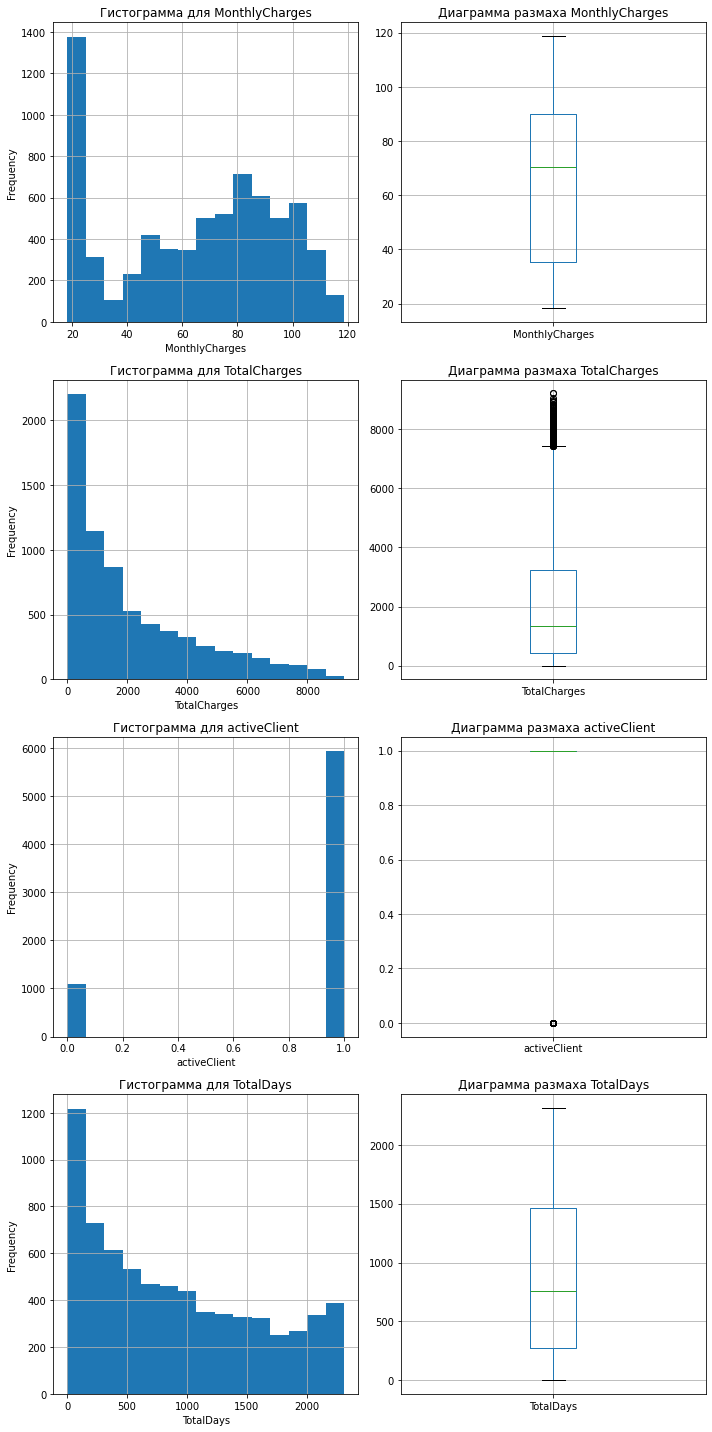

In [27]:
num_func(data_new.drop(columns=['customerID'], axis=1))

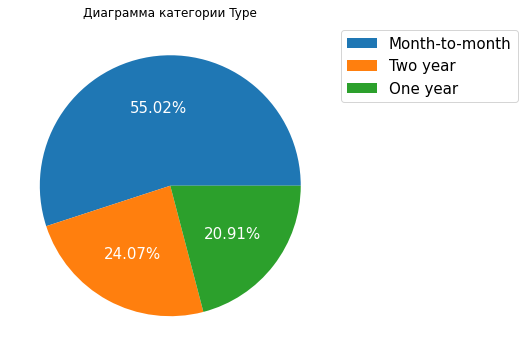

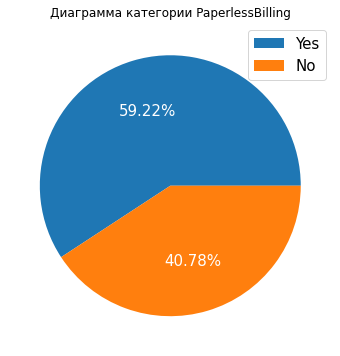

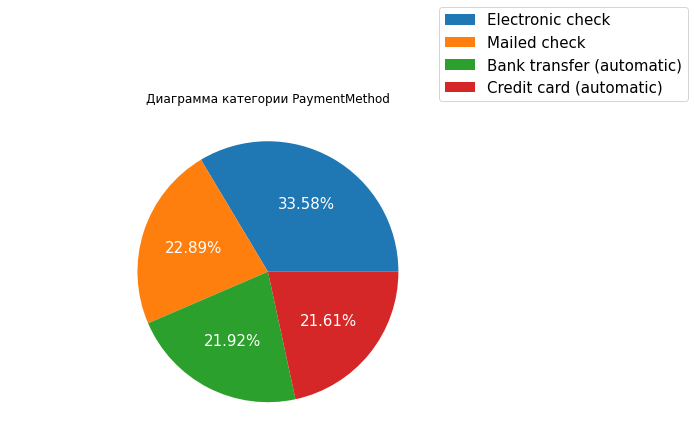

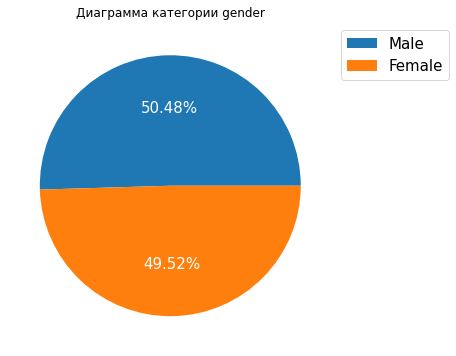

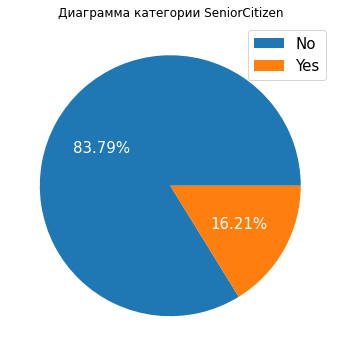

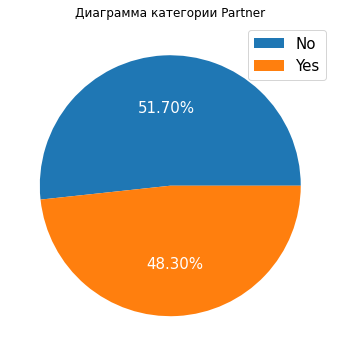

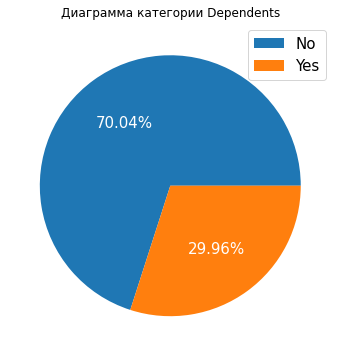

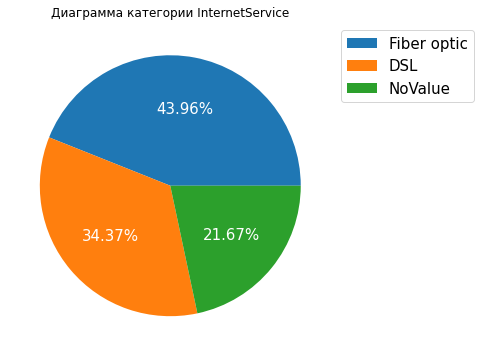

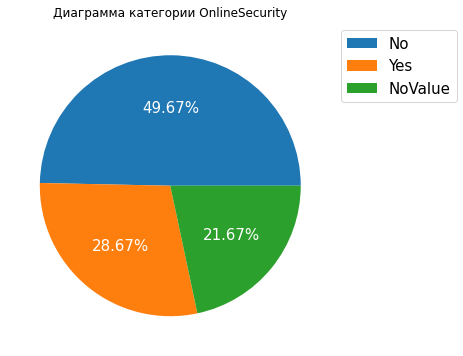

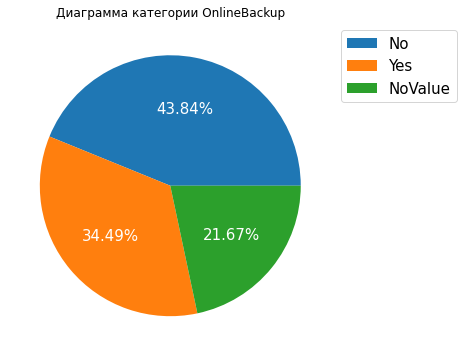

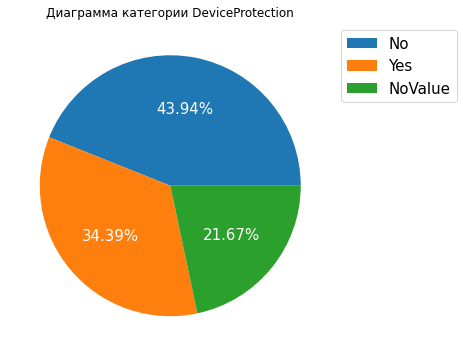

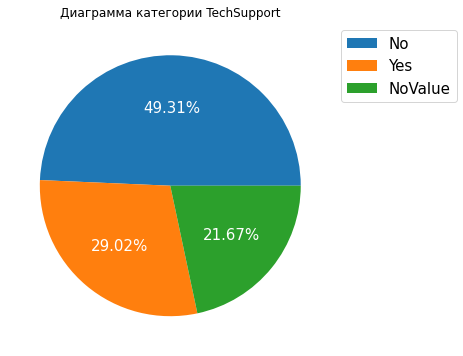

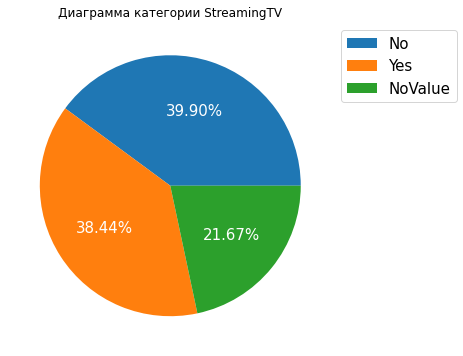

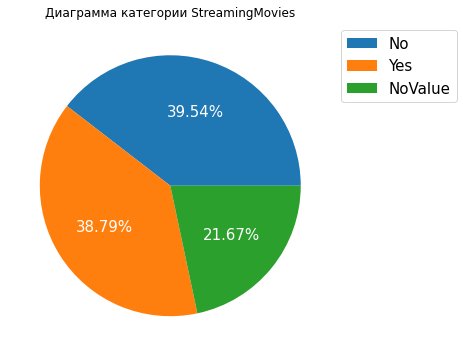

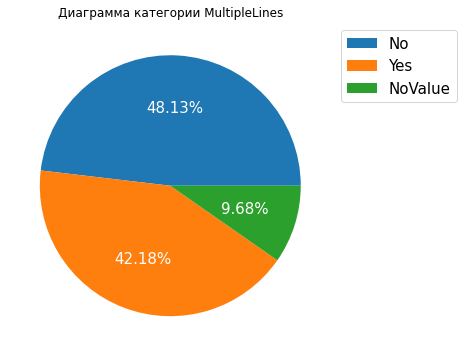

In [28]:
cat_func(data_new.drop(columns=['customerID'], axis=1))

__Вывод:__
- Около 80% договор еще активен - т.е. являются клиентами;
- Расходы за месяц не превышают 30, что может быть связано с отсутсвием у клиента доп.услуг, а платит в основном за связь;
- Пол клиентов распределен равномерно;
- Самые популярные категории, которые подключают ползователи - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies);
- 16.21% - пенсионеры;
- Около 55.02% оплачивают помесячно, что неудивительно - с учетом, что качество и количество предоставляемых услуг может отличаться у разных операторов связи,а оплачивая сразу за год или два ты "привязан" к оператору, а также с учетом, что пользователи привыкли оплачивать помесячно.

## Анализ мультиколлинеарности

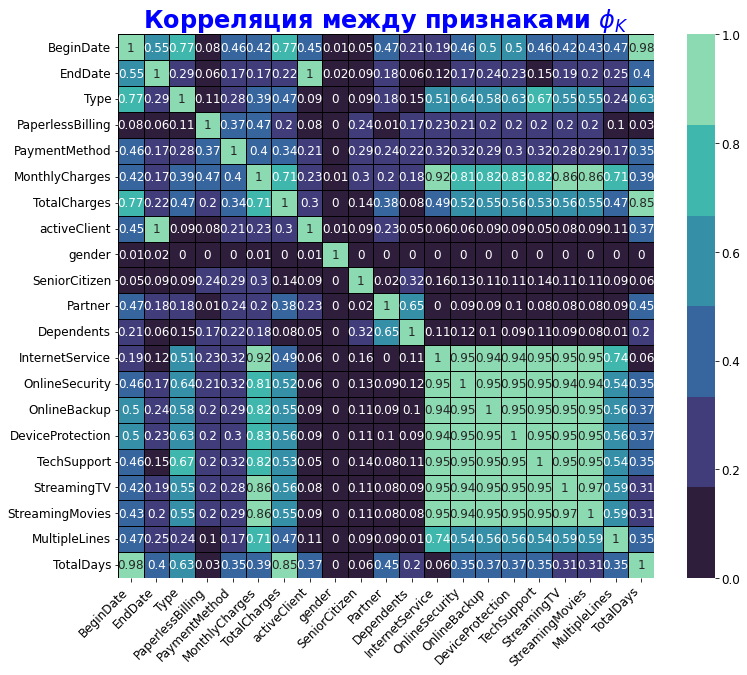

In [29]:
file = data_new[data_new.columns[data_new.columns != 'customerID']]

all_features = list(file.columns)

correlation = file[all_features].phik_matrix(interval_cols = ['MonthlyCharges','TotalCharges','TotalDays'])

plt.figure(figsize=(12,10))
colormap = sns.color_palette("mako")
plt.rc('font', size= 12)
chart = sns.heatmap(correlation.round(2), annot=True, cmap=colormap, linewidths=1, linecolor='black')
plt.title(r'Корреляция между признаками $\phi_K$', fontsize=24, fontweight="bold", color='blue')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_yticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right')
plt.show()

In [30]:
#Код ментора
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   activeСlient      7043 non-null   int64         
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   object        
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Можно заметить, что у нас присутствует проблема мультиколлинеарности в данных - корреляция между MonthlyCharges и InternetService, EndDate и activeClient, BeginDate и TotalDays.

## Подготовка данных для обучения модели

Избавимся от столбцов с мультиколлинеальностью

In [31]:
data_new = data_new.drop(['BeginDate', 'EndDate','gender','MonthlyCharges'], axis=1).set_index('customerID')

Наличие дубликатов в обучающей выборке не приносят дополнительной информации в модель, но создают необоснованный вес таким наблюдениям. Кроме того, увеличение объёма выборки, увеличивает расход вычислительных ресурсов и времени обучения. Узнаем их количество

In [32]:
print('Количество дубликатов:',data_new.duplicated().sum())

Количество дубликатов: 17


17 дубликатов. Удалим их.


In [33]:
data_new = data_new.drop_duplicates().reset_index(drop=True)

## Обучение моделей машинного обучения

In [34]:
X = data_new.drop(['activeСlient'], axis=1)
y = data_new['activeСlient']

Перечислим особенности данных:

- Одинадцать признаков:  Электронный расчётный лист, Является ли абонент пенсионером, Есть ли у абонента супруг или супруга,  Есть ли у абонента дети, Доп.услуги - нужно кодировать с помощью OneHotEncoder.
- Три признака: Тип оплаты, Тип подключения и  Тип платежа — нужно кодировать с помощью OrdinalEncoder.
- В признаках, закодированных этими методами, встречаются пропуски.
- Целевой признак — Действует ли контракт у клиента.
- Количественные признаки: Общие расходы абонента. Общее количество дней контракта - через StandardScaler.

In [35]:
ohe_columns = ['PaperlessBilling','SeniorCitizen','Partner','Dependents', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines','Type','InternetService','PaymentMethod']
num_columns = ['TotalCharges','TotalDays']

Разделим данные

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, 
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

Запустим обучение перебором, используя метод RandomizedSearchCV для экономии ресурсов и для ускорения работы алгоритма. Для оценки качества моделей будем использовать метрику ROC_AUC, как самую универсальную и сбалансированную метрику, которая не зависит от порога классификации.

In [37]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 


param_grid = [
    
    { 
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2,6),
        'models__min_samples_leaf': range(1,6),
        'models__max_features': range(2, 6),
        'models__max_depth': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },

    { 
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, 20],
        'models__min_samples_split': [2, 10],
        'models__min_samples_leaf': [2, 10],
        'models__n_estimators': [10, 50, 100], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='lbfgs',
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf',
            probability= True
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough'],
    },
    
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE
        )],
        'models__depth': [x for x in range(1,5)],
        'models__iterations': [x for x in range(100,1100, 100)],
        'models__learning_rate': [0.5, 0.6, 0.7]
    }
]

In [38]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=4,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
randomized_search.fit(X_train, y_train)

0:	learn: 0.4247722	total: 47.9ms	remaining: 38.2s
1:	learn: 0.3752908	total: 49.3ms	remaining: 19.7s
2:	learn: 0.3545964	total: 50.6ms	remaining: 13.4s
3:	learn: 0.3489865	total: 52.1ms	remaining: 10.4s
4:	learn: 0.3408778	total: 53.7ms	remaining: 8.54s
5:	learn: 0.3356117	total: 55.1ms	remaining: 7.29s
6:	learn: 0.3301970	total: 56.6ms	remaining: 6.41s
7:	learn: 0.3287698	total: 57.9ms	remaining: 5.73s
8:	learn: 0.3279952	total: 59.4ms	remaining: 5.22s
9:	learn: 0.3263167	total: 61.1ms	remaining: 4.83s
10:	learn: 0.3243988	total: 62.7ms	remaining: 4.5s
11:	learn: 0.3231076	total: 64.4ms	remaining: 4.23s
12:	learn: 0.3213427	total: 65.9ms	remaining: 3.99s
13:	learn: 0.3183276	total: 67.5ms	remaining: 3.79s
14:	learn: 0.3175029	total: 68.7ms	remaining: 3.6s
15:	learn: 0.3162162	total: 69.8ms	remaining: 3.42s
16:	learn: 0.3144864	total: 71.2ms	remaining: 3.28s
17:	learn: 0.3121042	total: 72.4ms	remaining: 3.15s
18:	learn: 0.3101051	total: 73.6ms	remaining: 3.02s
19:	learn: 0.3087016	tot

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['PaperlessBilling',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'O...
                                        {'models': [SVC(probability=True,
                                                        random_state=281024)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [<catboost.core.CatBoostClassifier object at 0x7fa918468e20>],
                                         'models__depth': [1, 2, 3, 4],
                                         'models__iterations': [100, 200, 300,
                                                                400, 500, 600,
                                                                700, 800, 900,
                                                                1000],
                                         'models__learning_rate': [0.5, 0.6,
                                                                   0.7]}],
                   random_state=281024, scoring='roc_auc')

## Выбор лучшей модели

In [39]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 {'models__learning_rate': 0.5, 'models__iterations': 400, 'models__depth': 2, 'models': <catboost.core.CatBoostClassifier object at 0x7fa918468e20>}
Метрика лучшей модели на тренировочной выборке: 0.9190763423512442


In [40]:
y_test_proba = randomized_search.predict_proba(X_test)

In [41]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9500073610599926


В резуьтате выбора модели на основе метрики ROC AUC лучшие результат у модели CatBoostClassifier с гиперпараметрами  {'models__learning_rate': 0.5, 'models__iterations': 400, 'models__depth': 2} показатель ROC AUC на тестовой выборке равен 0.95.
Цель проекта достигнут.

__ROC AUC__

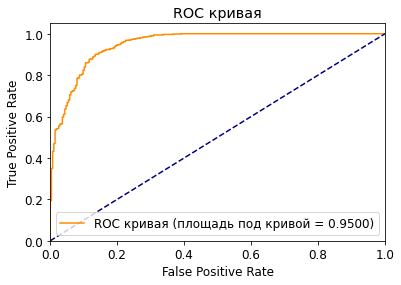

In [42]:
fpr, tpr, treshold = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Построение графика
plt.plot(
    fpr, 
    tpr, color='darkorange', 
    label='ROC кривая (площадь под кривой = %0.4f)' % roc_auc
)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривая')
plt.legend(loc="lower right")
plt.show()

__Показатель Accuracy__

In [43]:
predict = randomized_search.predict(X_test)

In [44]:
print('Показатель Accuracy:', accuracy_score(y_test, predict)) 

Показатель Accuracy: 0.9459305634604439


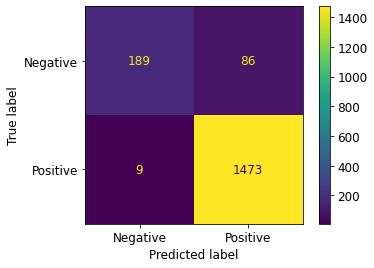

In [45]:
cm = confusion_matrix(y_test, predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot()
plt.show()

Анализ важности признаков

In [46]:
pd.DataFrame(
    randomized_search.best_estimator_[-1].feature_importances_, 
    index=randomized_search.best_estimator_[:-1].get_feature_names_out(),
    columns=['Важность признака']
).sort_values(by='Важность признака', ascending=False)

,Важность признака
num__TotalDays,75.119801
num__TotalCharges,9.657024
ohe__Type_Two year,2.607549
ohe__Partner_Yes,2.334317
ohe__MultipleLines_Yes,1.904509
ohe__Type_One year,1.469100
ohe__PaymentMethod_Mailed check,1.332217
ohe__OnlineBackup_Yes,1.037635
ohe__DeviceProtection_Yes,0.548522
ohe__Dependents_Yes,0.515973


__Вывод:__
В 95% случаев выбранная модель верно определяет класс объекта, что является хорошим результатом. Однако стоит учитывать дисбаланс классов, который может повлиять на качество предсказаний: модель лучше предсказывает объекты из более многочисленного класса. В данном проекте это класс 1 (договор не расторгнут). Подробная информация о количестве предсказанных объектов каждого класса представлена на матрице ошибок.

Анализ матрицы ошибок показывает, что модель корректно определяет большинство объектов класса 1 (на графике это горизонталь "Positive" — договор не расторгнут), допуская ошибки всего в 2% случаев. Однако при предсказании класса 0 (на графике горизонталь "Negative" — договор расторгнут) точность существенно ниже.

Важными признаками при обучении оказались:

- TotalDays - Количество дней контракта;
- TotalCharges - Общая сумма платежа;

## Общий вывод и рекомендации заказчику

На основе представленных данных можно сделать следующий общий вывод о проведенных исследованиях:

__1. Предобработка и анализ данных__

Все исследования включали тщательную предобработку данных. Она включала обработку пропусков, изменение типов данных, переименование столбцов, масштабирование и кодирование признаков. В некоторых случаях были добавлены новые признаки (например, целевой признак actualClient, который показывал - остался ли клиент и не рассторг ли он договор, или TotalDays, показывающий продолжительность использования услуг).

Исследовательский анализ данных выявил важные корреляции между признаками и целевой переменной, что позволило лучше понять поведение клиентов и выделить ключевые факторы, влияющие на их решение о расторжении договора.

__2. Модели и их обучение__

Во всех проектах была проведена работа по обучению и сравнению различных моделей машинного обучения, таких как:

    Logistic Regression
    DecisionTreeClassifier
    RandomForestClassifier
    KNeighborsClassifier
    CatBoostClassifier
    SVC

Модель CatBoostClassifier с ги показала себя наиболее эффективной в большинстве случаев и была выбрана для использования в продакшене. Лучшие результаты по метрике ROC-AUC для этой модели составил 0.947, что превысило требуемые показатели.

__3. Анализ результатов и рекомендации__

На тестовых данных модели показали хорошее качество предсказаний, особенно CatBoostClassifier с оптимизированными гиперпараметрами. Однако были замечены ошибки второго рода, когда модель ошибочно предсказывала, что клиент не откажется от услуг, хотя он планировал разорвать договор. Это имеет значительное значение для бизнеса, так как упущенные клиенты могут привести к финансовым потерям.

Для улучшения качества предсказаний и повышения метрик предлагается:

    Собрать дополнительные данные о клиентах и услугах, например, данные об использовании тарифов.
    Оптимизировать существующие признаки и добавить новые, чтобы улучшить предсказательную способность моделей.
    Рассмотреть применение более сложных моделей, например, нейронных сетей на основе Keras (TensorFlow), для дальнейшего улучшения результатов.

__4. Рекомендации по внедрению__

Рекомендовано использовать CatBoostClassifier с подобранными гиперпараметрами в продакшене для предсказания оттока клиентов. Внедрение данной модели может помочь снизить уровень оттока и повысить удовлетворенность клиентов, предоставляя возможность компании принимать проактивные меры по удержанию клиентов.

Для дальнейшего повышения качества моделей стоит:

    Рассмотреть возможность интеграции новых источников данных, таких как результаты опросов клиентов.

Таким образом, все проведенные исследования достигли поставленных целей, и модели показали себя эффективно в задаче предсказания оттока клиентов телекоммуникационных услуг.